In [130]:
import os
import numpy as np
from scipy import integrate, linalg
from matplotlib import pyplot as py
from IPython.display import Image
%matplotlib inline

## Drag Reduction System in Formula 1

The Drag Reduction System, or DRS, is a system that temporarily reduces the drag from the rear wing of a Formula One car. This provides the driver with a slight increase in top speed that is neccecary when he is looking to overtake another driver. The rules for when it may be used are quite strict; only in designated zones and if a driver is within one second of his rival.

![Wing2](img/wing2.jpg)

It is a system of two wings. The first, larger wing is fixed in its posistion. When disabled, the second wing must maintain a gap of 10mm between itself and the closest point of the main wing. When the driver activates the DRS system, this 10mm gap is increased to 50mm, thereby reducing the overall drag of the wing and allowing for the driver to execute the overtake.

![Wing](img/wing.png)

In this model, we will look at the function of a typical DRS system in the rear wing of an F1 car. We will visualize the flow around the wing system with streamlines, as well as plot pressure coeficcients in the system. Then we will determine the percent decrease in drag as well as downforce. How does activating the system effect the dynamics of the F1 car?


Formula One wing profiles are generally bespoke and private to each team. However, based on Formula One rules, certain assumptions can be made on the size of the wing. For the main wing in this model, a NACA 2408 foil with a chord length and curvature of 290mm and 600mm respectively was chosen. The profile and location of the flap blade is what will be changed and analyzed between iterations.

The combinations of wings are as follows, each with a 10mm and 50mm seperation gap.
   
       NACA 2408(290mm Length, 600mm curvature) (MAIN) | NACA 2415(120mm L, 250mm Curv.) (FLAP)
       NACA 2408(290mm Length, 400mm curvature) (MAIN) | NACA 2415(120mm L, 175mm Curv.) (FLAP)
       
A second set of airfoils were analyized with additional curvature. A typical F1 rear wings has severe curvature, so the effect on drag and downforce is to be analyzed with additional foil curvature.

## Calculations
We will begin by loading the airfoil geometry from http://airfoilplotter.com. Each airfoil has 200 points, a closed trailing edge, and linear spacing between the points. Cosine spacing was not implimented here, as it intereferes with the way the system generates panels for analysis.


In [131]:
#Load Airfoils - Files easily changed for size
main_foil = os.path.join('naca2408-290x604.csv')
with open (main_foil, 'r') as file_name:
    x_main1, y_main1 = np.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)
    
N = x_main1.size-1

main_foil2 = os.path.join('naca2408-290x400.csv')
with open (main_foil2, 'r') as file_name:
    x_main2, y_main2 = np.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)
    

In [132]:
#This function transforms the location of the flap airfoil
def transform(xc, yc, foil, xi, yi, deg):
    
    flap_foil = os.path.join(foil)
    with open (flap_foil, 'r') as file_name:
        x_flap, y_flap = np.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)
        
    angle = np.radians(deg)

    xn = xi + np.cos(angle) * (x_flap - xi) - np.sin(angle) * (y_flap - yi) + xc
    yn = yi + np.sin(angle) * (x_flap - xi) + np.cos(angle) * (y_flap - yi) + yc

    
    return xn, yn

Here, the location of the airfoil flap was manually chosen. Again a 10mm and 50mm gap were chosen for each case

In [133]:
x_new1, y_new1 = transform(250, -75, 'naca2415-120x250.csv', 0, 0, -30)
x_new2, y_new2 = transform(225, -115, 'naca2415-120x250.csv', 0, 0, -10)

x_new3, y_new3 = transform(250, -110, 'naca2415-120x175.csv', 0, 0, -40)
x_new4, y_new4 = transform(200, -150, 'naca2415-120x175.csv', 0, 0, -10)

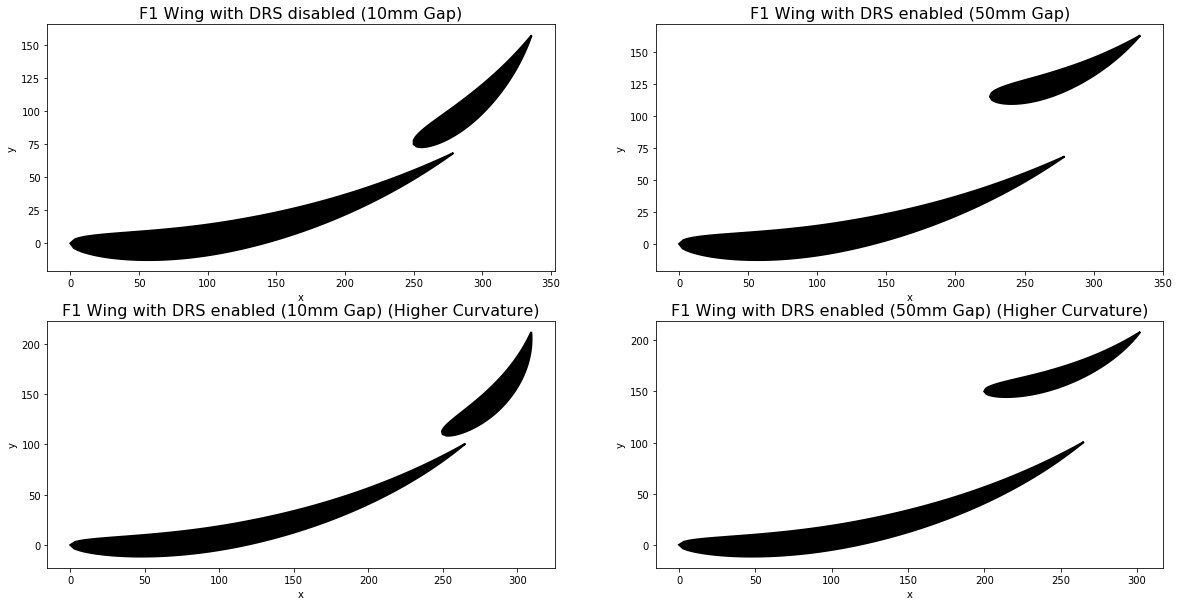

In [134]:
width = 20
py.figure(figsize=(width, width/2))
py.subplot(221)
py.xlabel('x')
py.ylabel('y')
py.title('F1 Wing with DRS disabled (10mm Gap)', fontsize=16)
py.fill(x_main1, -y_main1, color='k', linestyle='-', linewidth=2)
py.fill(x_new1, -y_new1, color='k', linestyle='-', linewidth=2)
py.subplot(222)
py.fill(x_main1, -y_main1, color='k', linestyle='-', linewidth=2)
py.fill(x_new2, -y_new2, color='k', linestyle='-', linewidth=2)
py.xlabel('x')
py.ylabel('y')
py.title('F1 Wing with DRS enabled (50mm Gap)', fontsize=16)
py.subplot(223)
py.fill(x_main2, -y_main2, color='k', linestyle='-', linewidth=2)
py.fill(x_new3, -y_new3, color='k', linestyle='-', linewidth=2)
py.xlabel('x')
py.ylabel('y')
py.title('F1 Wing with DRS enabled (10mm Gap) (Higher Curvature)', fontsize=16)
py.subplot(224)
py.fill(x_main2, -y_main2, color='k', linestyle='-', linewidth=2)
py.fill(x_new4, -y_new4, color='k', linestyle='-', linewidth=2)
py.xlabel('x')
py.ylabel('y')
py.title('F1 Wing with DRS enabled (50mm Gap) (Higher Curvature)', fontsize=16);

Here, the two wings are modeled and the geometry is confirmed to be correct. When the wing is 'activated', the gap between the foils increases as the smaller flap roatates out of the way. 

According to F1 rules, the rotation occurs 20mm from the trailing edge of the flap. Because the flap has a chord length of 120, or ~16.6% from the end. The next step is turning these clusters of points into panels so we can perform our analysis.

## Functions and Classes
Following are all of the functions used in this report.

In [135]:
class Panel:
    
    def __init__(self, xa, ya, xb, yb):
       
        self.xa, self.ya = xa, ya  # panel starting-point
        self.xb, self.yb = xb, yb  # panel ending-point
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2  # panel center
        self.length = np.sqrt((xb - xa)**2 + (yb - ya)**2)  # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb - xa <= 0.0:
            self.beta = np.arccos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = np.pi + np.arccos(-(yb - ya) / self.length)
        
        # panel location
        if self.beta <= np.pi:
            self.loc = 'upper'  # upper surface
        else:
            self.loc = 'lower'  # lower surface
        
        self.sigma = 0.0  # source strength
        self.vt = 0.0  # tangential velocity
        self.cp = 0.0  # pressure coefficient

In [136]:
def define_panels(x, y, N):
    
    # create panels
    panels = np.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x[i], y[i], x[i + 1], y[i + 1])
    
    return panels

In [137]:
class Freestream:
    
    def __init__(self, u_inf, alpha):
        
        self.u_inf = u_inf
        self.alpha = np.radians(alpha)

In [138]:
def integral(x, y, panel, dxdz, dydz):
    
    def integrand(s):
        return (((x - (panel.xa - np.sin(panel.beta) * s)) * dxdz +
                (y - (panel.ya + np.cos(panel.beta) * s)) * dydz) /
               ((x - (panel.xa - np.sin(panel.beta) * s))**2 +
               (y - (panel.ya + np.cos(panel.beta) * s))**2))
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [139]:
#source contribution
def source_contribution_normal(panels):
    
    A = np.empty((panels.size, panels.size), dtype=float)
    
    # source contribution on a panel from itself
    np.fill_diagonal(A, 0.5)
    
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / np.pi * integral(panel_i.xc, panel_i.yc, 
                                                    panel_j,
                                                    np.cos(panel_i.beta),
                                                    np.sin(panel_i.beta))
    return A

In [140]:
def vortex_contribution_normal(panels):
    
    A = np.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    np.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5 / np.pi * integral(panel_i.xc, panel_i.yc, 
                                                     panel_j,
                                                     np.sin(panel_i.beta),
                                                     -np.cos(panel_i.beta))
    return A

In [141]:
def kutta_condition(A_source, B_vortex):

    b = np.empty((2,A_source.shape[0]+2), dtype=float)
    A = np.empty((A_source.shape[0], A_source.shape[0]+2), dtype=float)
    
    A[:, :-2] = B_vortex
    A[:, -2] = -np.sum(A_source[:,:N], axis=1)
    A[:, -1] = -np.sum(A_source[:,N:], axis=1)
   
    b[0,:] = A[0, :] + A[N-1, :]
    b[1,:] = A[N, :] + A[-1, :]

    return b

In [142]:
def build_singularity_matrix(A_source, B_vortex):

    A = np.empty((A_source.shape[0]+2, A_source.shape[1]+2), dtype=float)
    A[:-2, :-2] = A_source
    A[:-2, -2] = np.sum(B_vortex[:,:N], axis=1)
    A[:-2, -1] = np.sum(B_vortex[:,N:], axis=1)
    A[-2:, :] = kutta_condition(A_source, B_vortex)


    return A

In [143]:
def build_freestream_rhs(panels, freestream):
   
    b = np.empty(panels.size+2,dtype=float)

    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)
    
    b[-2] = -freestream.u_inf*( np.sin(freestream.alpha-panels[0].beta)
                              +np.sin(freestream.alpha-panels[N-1].beta) )
    b[-1] = -freestream.u_inf*( np.sin(freestream.alpha-panels[N].beta)
                              +np.sin(freestream.alpha-panels[-1].beta) )
    return b

In [144]:
def get_velocity_field(panels, freestream, X, Y):
  
    # freestream contribution
    u = freestream.u_inf * np.cos(freestream.alpha) * np.ones_like(X, dtype=float)
    v = freestream.u_inf * np.sin(freestream.alpha) * np.ones_like(X, dtype=float)
    
    # add the contribution from each source (superposition powers!!!)
    vec_intregral = np.vectorize(integral)
    for panel in panels:
        u += panel.sigma / (2.0 * np.pi) * vec_intregral(X, Y, panel, 1.0, 0.0)
        v += panel.sigma / (2.0 * np.pi) * vec_intregral(X, Y, panel, 0.0, 1.0)
    
    return u, v

In [145]:
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    
    A = np.empty((panels.size, panels.size + 2), dtype=float)
    A[:, :-2] = B_vortex
    A[:, -2] = -np.sum(A_source[:,:N], axis=1)
    A[:, -1] = -np.sum(A_source[:,N:], axis=1)
    b = freestream.u_inf * np.sin([freestream.alpha - panel.beta 
                                      for panel in panels])
    strengths = np.append([panel.sigma for panel in panels], gamma)
    tangential_velocities = np.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [146]:
def compute_pressure_coefficient(panels, freestream):
    
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / freestream.u_inf)**2

In [147]:
def plotstreamlines(X, Y, u, v, x_main, y_main, x_flap, y_flap, title='Title'):
    width = 10
    py.figure(figsize=(width, width))
    py.xlabel('x', fontsize=16)
    py.ylabel('y', fontsize=16)
    py.streamplot(X, Y, u, v,
                  density=2, linewidth=1, arrowsize=1, arrowstyle='->')
    py.fill(x_main,
            y_main,
            color='k', linestyle='solid', linewidth=0.5, zorder=2)
    py.fill(x_flap,
            y_flap,
            color='k', linestyle='solid', linewidth=0.5, zorder=2)
    py.axis('scaled', adjustable='box')
    py.xlim(x_start, x_end)
    py.ylim(y_start, y_end)
    py.title(title, fontsize=16)
    py.gca().invert_yaxis();

In [148]:
def plotcp(X, Y, x_main, y_main, x_flap, y_flap, cp, title):
    width = 10
    py.figure(figsize=(width, width))
    py.xlabel('x', fontsize=16)
    py.ylabel('y', fontsize=16)
    contf = py.contourf(X, Y, cp,
                        levels=np.linspace(-2.0, 1.0, 100), extend='both')
    cbar = py.colorbar(contf,
                       orientation='vertical',
                       shrink=0.5, pad = 0.1,
                       ticks=[-2.0, -1.0, 0.0, 1.0])
    cbar.set_label('$C_p$', fontsize=16)
    py.fill(x_main,
            y_main,
            color='k', linestyle='solid', linewidth=0.5, zorder=2)
    py.fill(x_flap,
            y_flap,
            color='k', linestyle='solid', linewidth=0.5, zorder=2)
    py.axis('scaled', adjustable='box')
    py.xlim(x_start, x_end)
    py.ylim(y_start, y_end)
    py.title(title, fontsize=16)
    py.gca().invert_yaxis();

## Panel Definition

Now we will define our airfoil geometry as panels. The main foil is held constant throughout all the test. The flap is allowed to change position. Each system is then combined using the numpy.append command. As each system of panels was each (200,), the combination of the two foils will have a shape (400,). If we had used foils with cosine-spacing, the numpy.append command would not work correctly and we would have a final shape of (234,), which does not yield correct results.

In [149]:
main1 = define_panels(x_main1, y_main1, N)
flap1 = define_panels(x_new1, y_new1, N)
flap2 = define_panels(x_new2, y_new2, N)
naca2408241510mm = np.append(main1, flap1)
naca2408241550mm = np.append(main1, flap2)

main2 = define_panels(x_main2, y_main2, N)
flap3 = define_panels(x_new3, y_new3, N)
flap4 = define_panels(x_new4, y_new4, N)
naca10mm = np.append(main2, flap3)
naca50mm = np.append(main2, flap4)

freestream = Freestream(1.0, 0.0)

Here, the source and vortex contributions are calculated. We also find gamma in order to compute the pressure coefficient later down the road.

In [150]:
#1st Iteration - 10mm Gap
source_241510mm = source_contribution_normal(naca2408241510mm)
vortex_241510mm = vortex_contribution_normal(naca2408241510mm)
A_241510mm = build_singularity_matrix(source_241510mm, vortex_241510mm)
b_241510mm = build_freestream_rhs(naca2408241510mm, freestream)

sigma_241510mm = np.linalg.solve(A_241510mm, b_241510mm)
for i, panel in enumerate(naca2408241510mm):
    panel.sigma = sigma_241510mm[i] 
gamma_241510mm = sigma_241510mm[-2:]

#1nd Iteration - 50mm Gap
source_241550mm = source_contribution_normal(naca2408241550mm)
vortex_241550mm = vortex_contribution_normal(naca2408241550mm)
A_241550mm = build_singularity_matrix(source_241550mm, vortex_241550mm)
b_241550mm = build_freestream_rhs(naca2408241550mm, freestream)

sigma_241550mm = np.linalg.solve(A_241550mm, b_241550mm)
for i, panel in enumerate(naca2408241550mm):
    panel.sigma = sigma_241550mm[i] 
gamma_241550mm = sigma_241550mm[-2:]

#2nd Iteration - 10mm Gap
source_10mm = source_contribution_normal(naca10mm)
vortex_10mm = vortex_contribution_normal(naca10mm)
A_10mm = build_singularity_matrix(source_10mm, vortex_10mm)
b_10mm = build_freestream_rhs(naca10mm, freestream)

sigma_10mm = np.linalg.solve(A_10mm, b_10mm)
for i, panel in enumerate(naca10mm):
    panel.sigma = sigma_10mm[i] 
gamma_10mm = sigma_10mm[-2:]

#2nd Iteration - 50mm Gap
source_50mm = source_contribution_normal(naca50mm)
vortex_50mm = vortex_contribution_normal(naca50mm)
A_50mm = build_singularity_matrix(source_50mm, vortex_50mm)
b_50mm = build_freestream_rhs(naca50mm, freestream)

sigma_50mm = np.linalg.solve(A_50mm, b_50mm)
for i, panel in enumerate(naca50mm):
    panel.sigma = sigma_50mm[i] 
gamma_50mm = sigma_50mm[-2:]

In [151]:
compute_tangential_velocity(naca2408241510mm, freestream, gamma_241510mm, source_241510mm, vortex_241510mm)
compute_pressure_coefficient(naca2408241510mm, freestream)
compute_tangential_velocity(naca2408241550mm, freestream, gamma_241550mm, source_241550mm, vortex_241550mm)
compute_pressure_coefficient(naca2408241550mm, freestream)

compute_tangential_velocity(naca10mm, freestream, gamma_10mm, source_10mm, vortex_10mm)
compute_pressure_coefficient(naca50mm, freestream)
compute_tangential_velocity(naca50mm, freestream, gamma_50mm, source_50mm, vortex_50mm)
compute_pressure_coefficient(naca50mm, freestream)

## Freestream Analysis
We have created panels from the two airfoil shapes and combined them into one. 

   Here, the resolution for the streamline plot may be changed. Due to the size of these calculations, speed is inversely proportional to resolution. To enable efficient debugging, the resultion may be lowered. When final results are desired, this resoltion may be increased and run independantly.

In [152]:
# define a mesh grid
n = 40  # number of points in the x and y directions
x_start, x_end = -100, 400
y_start, y_end = -250, 50
X, Y = np.meshgrid(np.linspace(x_start, x_end, n),
                      np.linspace(y_start, y_end, n))

Finally, compute the velocity field of the combined foils. This resolution set above has a dramatic effect on the results yielded from the velocity field.

In [153]:
# compute the velocity field on the mesh grid
u_241510mm, v_241510mm = get_velocity_field(naca2408241510mm, freestream, X, Y)
u_241550mm, v_241550mm = get_velocity_field(naca2408241550mm, freestream, X, Y)

cp_241510mm = 1.0 - (u_241510mm**2 + v_241510mm**2) / freestream.u_inf**2
cp_241550mm = 1.0 - (u_241550mm**2 + v_241550mm**2) / freestream.u_inf**2

u_10mm, v_10mm = get_velocity_field(naca10mm, freestream, X, Y)
u_50mm, v_50mm = get_velocity_field(naca50mm, freestream, X, Y)

cp_10mm = 1.0 - (u_10mm**2 + v_10mm**2) / freestream.u_inf**2
cp_50mm = 1.0 - (u_50mm**2 + v_50mm**2) / freestream.u_inf**2


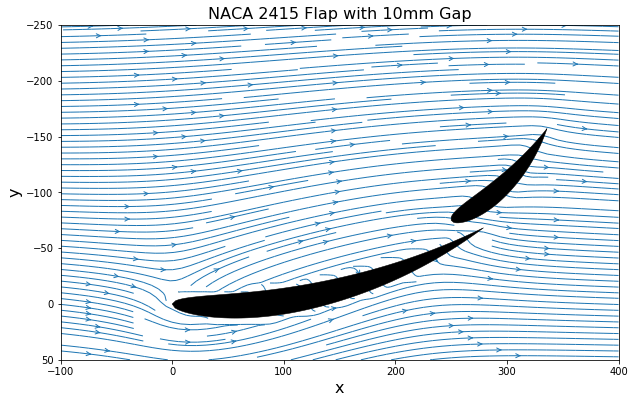

In [154]:
plotstreamlines(X, Y, u_241510mm, v_241510mm, x_main1, 
    y_main1, x_new1, y_new1, 'NACA 2415 Flap with 10mm Gap')

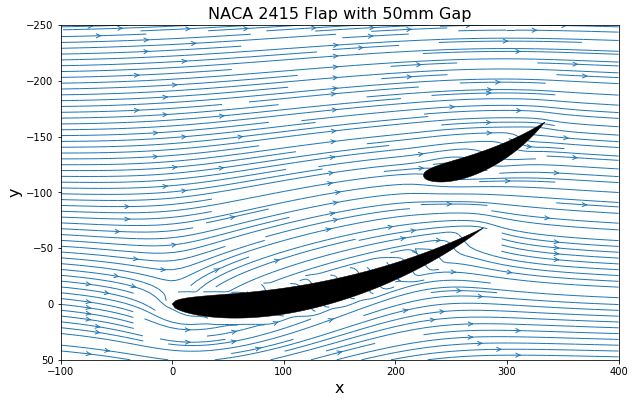

In [155]:
plotstreamlines(X, Y, u_241550mm, v_241550mm, x_main1, 
    y_main1, x_new2, y_new2, 'NACA 2415 Flap with 50mm Gap')

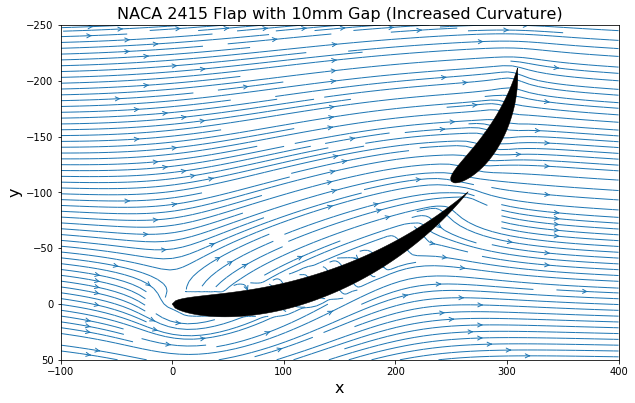

In [156]:
plotstreamlines(X, Y, u_10mm, v_10mm, x_main2, 
    y_main2, x_new3, y_new3, 'NACA 2415 Flap with 10mm Gap (Increased Curvature)')

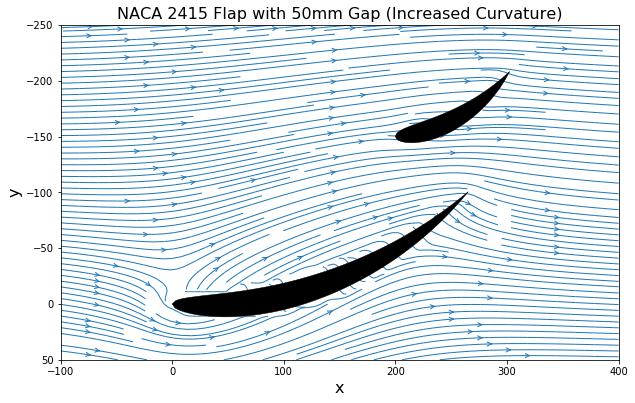

In [157]:
plotstreamlines(X, Y, u_50mm, v_50mm, x_main2, 
    y_main2, x_new4, y_new4, 'NACA 2415 Flap with 50mm Gap (Increased Curvature)')

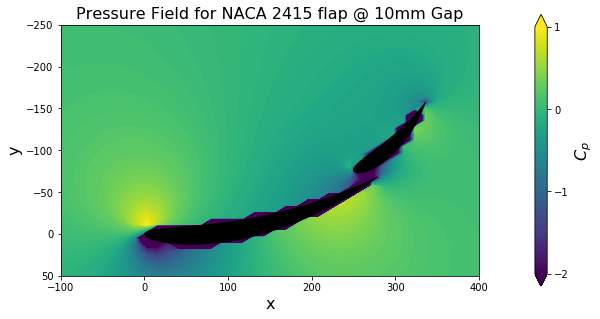

In [158]:
plotcp(X, Y, x_main1, y_main1, x_new1, y_new1, cp_241510mm, 'Pressure Field for NACA 2415 flap @ 10mm Gap')

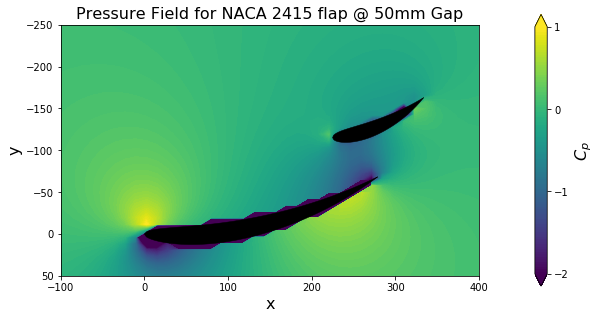

In [159]:
plotcp(X, Y, x_main1, y_main1, x_new2, y_new2, cp_241550mm, 'Pressure Field for NACA 2415 flap @ 50mm Gap')

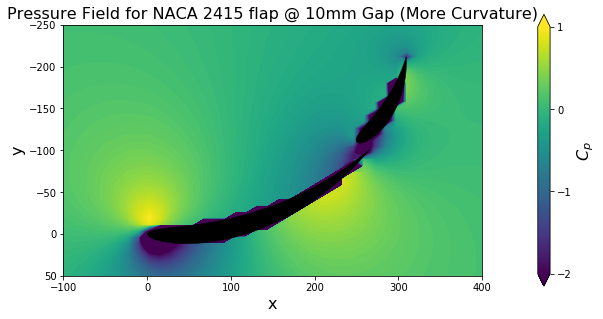

In [160]:
plotcp(X, Y, x_main2, y_main2, x_new3, y_new3, cp_10mm, 'Pressure Field for NACA 2415 flap @ 10mm Gap (More Curvature)')

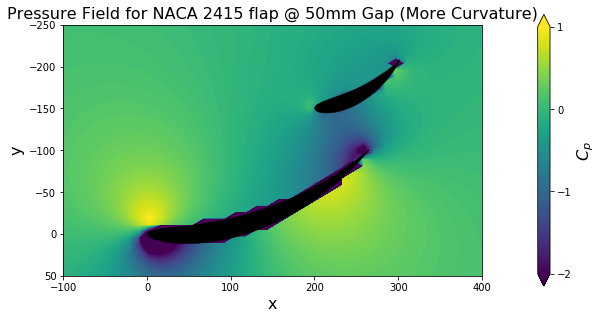

In [161]:
plotcp(X, Y, x_main2, y_main2, x_new4, y_new4, cp_50mm, 'Pressure Field for NACA 2415 flap @ 50mm Gap (More Curvature)')

Looking at the pressure coefficient graphs when the systems are open, there is a higher pressure zone towards the leading edge of the flap airfoil

Now that we have the two scenarios modeled, how will activating the system impact the air's effects on the car? We will look at downforce and drag to make our conclusions.

## Downforce and Drag
What effect does opening the wing have on drag? What percentage degcrease in drag is experienced? How does this relate to the decrease in effective downforce?

As drag is reduced, so is downforce. Downforce is desireable in Formula One cars, as it keeps the car planted to the control surface at high speeds (200+MPH). It is what allows formula one cars to maintain high levels of grip through fast corners. Without it, a driver may be able to reach a higher speed, but at the risk of less traction.

Below are the results for each system analyzed. The low curvature models were compared with eachother, as were the high curvature models. The systems were then compared with each other in the open and closed positions. Is there a noticable change between the two models? What effect does this have on downforce and drag?

In [162]:
drag_closed1 = 0
drag_closed2 = 0
drag_open1 = 0
drag_open2 = 0

In [163]:
for panel in naca2408241510mm:
    drag_closed1 += panel.cp*np.cos(panel.beta)*panel.length
for panel in naca2408241550mm:
    drag_open1 += panel.cp*np.cos(panel.beta)*panel.length
for panel in naca50mm:
    drag_open2 += panel.cp*np.cos(panel.beta)*panel.length
for panel in naca10mm:
    drag_closed2 += panel.cp*np.cos(panel.beta)*panel.length

In [164]:
def difference( num1, num2):
    dif = (abs(abs(num1)-abs(num2))/(abs(num1)))*100
    return dif

In [165]:
dif_pair1 = difference(drag_closed1, drag_open1)
dif_pair2 = difference(drag_closed2, drag_open2)
dif_closed = difference(drag_closed1, drag_closed2)
dif_open = difference(drag_open1, drag_open2)

In [166]:
print('The decrease in drag for the first system, \n(600mm MAIN and 250mm FLAP Curvature) is: {:0.1f}%'.format(dif_pair1))

The decrease in drag for the first system, 
(600mm MAIN and 250mm FLAP Curvature) is: 80.6%


In [167]:
print('The decrease in drag for the second system, \n(400mm MAIN and 175mm FLAP Curvature) is: {:0.1f}%'.format(dif_pair2))

The decrease in drag for the second system, 
(400mm MAIN and 175mm FLAP Curvature) is: 77.8%


In [168]:
print('The percent decrease in drag betwen the high and \nlow curvature in the OPEN position is: {:0.1f}%'.format(-dif_open))

The percent decrease in drag betwen the high and 
low curvature in the OPEN position is: -87.5%


In [169]:
print('The percent decrease in drag betwen the high and \nlow curvature in the CLOSED position is: {:0.1f}%'.format(-dif_closed))

The percent decrease in drag betwen the high and 
low curvature in the CLOSED position is: -79.5%


Because the lift and drag equations are only slightly different, we will run the same caculations again for downforce.

In [170]:
df_closed1 = 0
df_closed2 = 0
df_open1 = 0
df_open2 = 0
for panel in naca2408241510mm:
    df_closed1 -= panel.cp*np.sin(panel.beta)*panel.length
for panel in naca2408241550mm:
    df_open1 -= panel.cp*np.sin(panel.beta)*panel.length
for panel in naca50mm:
    df_open2 -= panel.cp*np.sin(panel.beta)*panel.length
for panel in naca10mm:
    df_closed2 -= panel.cp*np.sin(panel.beta)*panel.length
df_pair1 = difference(df_closed1, df_open1)
df_pair2 = difference(df_closed2, df_open2)
df_closed = difference(df_closed1, df_closed2)
df_open = difference(df_open1, df_open2)

In [171]:
print('The percent decrease in downforce for the first system: {:0.1f}%\n(600mm and 250mm Curvature)'.format(-df_pair1))

The percent decrease in downforce for the first system: -2.9%
(600mm and 250mm Curvature)


In [172]:
print('The percent decrease in downforce for the second system: {:0.1f}%\n(400mm and 175mm Curvature)'.format(-df_pair2))

The percent decrease in downforce for the second system: -9.5%
(400mm and 175mm Curvature)


In [173]:
print('The percent increase in downforce between \nthe low and high curvature models (CLOSED position) is: {:0.1f}%'.format(df_closed))

The percent increase in downforce between 
the low and high curvature models (CLOSED position) is: 15.4%


In [174]:
print('The percent increase in downforce between \nthe low and high curvature models (OPEN position) is: {:0.1f}%'.format(df_open))

The percent increase in downforce between 
the low and high curvature models (OPEN position) is: 30.2%


## Results
We can see here that the drag does in fact decrease with the DRS system activated. Downforce is also reduced, but not as much as expected. This means that the driver will not have to make major driving changes to compensate for the lack of downforce. As other components on the car will also be providing downforce, the wing is only one part of an F1 car's aerodynamic system. 

The system yields overall ~80% reduction in drag when activated. A greater factor of drag reduction was found in the first system with lower curvature levels. It also experiences less reduction of overall downforce when DRS is activated. This shows that there is clearly a limit to the effective curvature added to an Formula 1 rear wing. Further iterations with different airfoil contours would explore the limit of this, and which profiles are most desirable. This also demonstrates that the profile of the airfoil has a greater effect on downforce than the DRS system itself does. 

The speed of the computations could also become an issue. As resolution and the number of airfoils increases, so does the computation time for the program. Simplifying the code to allow for direct velocity field and pressure coefficient calculations would speed this up, as currently the program must retrace some of its steps to perform the calculations. 